In [32]:
import numpy as np 
from numpy.linalg import cond
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt




In [33]:
#method to find Hessian matrix: Complete the code
def evalh(x): 
  return np.array([[-2048*x[1]+6144*x[0]**2+2,-2048*x[0]],[-2048*x[0],1024]])

In [34]:
#method to find the condition number of any square matrix: : Complete the code
def find_condition_number(A):
  return cond(A)

In [35]:
#The method defines a way to construct D_k matrix used in scaling the gradient in the modified gradient descent scheme
def compute_D_k(x):
  return np.array([[1/(evalh(x)[0][0]), 0], [0, 1/(evalh(x)[1][1])]])


In [36]:
def compute_D_k_newton(x):
    return np.linalg.inv(evalh(x))

In [37]:
#Now we will define a Python function which will compute and return the objective function value 
def evalf(x):  
  return (512*(x[1]-x[0]**2)**2 + (4-x[0])**2)


In [38]:
#Now we will define a Python function which will compute and return the gradient value as a numpy array 
def evalg(x):  
  return np.array([-2048*x[0]*(x[1]-x[0]**2)+2*x[0]-8, 1024*(x[1]-x[0]**2)])

In [39]:
#Complete the module to compute the steplength by using the closed-form expression
def compute_steplength_backtracking(x, gradf, alpha_start, rho, gamma, *args): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  #Complete the code 
  alpha = alpha_start
  pk = -gradf
  while evalf(np.add(x, alpha*pk)) > np.add(evalf(x), gamma*alpha*np.dot(gradf.T,pk)):
    alpha = rho*alpha

  return alpha
  

In [40]:
def compute_steplength_backtracking_scaled_direction(x, gradf, direction, alpha_start, rho, gamma, *args): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(direction) is np.ndarray and len(direction) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  
  
  #Complete the code 
  alpha = alpha_start
  pk = -gradf
  while evalf(np.add(x, alpha*np.dot(direction,pk))) > np.subtract(evalf(x), gamma*alpha*np.dot(np.dot(direction,gradf), gradf)):
    alpha = rho*alpha
  return alpha

In [41]:
#line search type 
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2
CONSTANT_STEP_LENGTH = 3

In [42]:
# D_k choice type
newton = 4
diagonal_approx = 5

In [43]:
#complete the code for gradient descent to find the minimizer
def find_minimizer_gd(start_x, tol, line_search_type, *args):
    #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
    assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
    assert type(tol) is float and tol>=0 

    x = start_x
    g_x = evalg(x)
    condition_array = [find_condition_number(evalh(x))]

    #initialization for backtracking line search
    if(line_search_type == BACKTRACKING_LINE_SEARCH):
        alpha_start = args[0]
        rho = args[1]
        gamma = args[2]

    k = 0

    while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking(x,g_x, alpha_start,rho, gamma) #call the new function you wrote to compute the steplength
        elif line_search_type == CONSTANT_STEP_LENGTH: #do a gradient descent with constant step length
            step_length = 0.1
        else:  
            raise ValueError('Line search type unknown. Please check!')
        
        #implement the gradient descent steps here   
        x = np.subtract(x, np.multiply(step_length,g_x)) #update x = x - step_length*g_x
        k += 1 #increment iteration
        g_x = evalg(x) #compute gradient at new point
        condition_array.append(find_condition_number(evalh(x)))

    return x, evalf(x), k, condition_array


In [44]:
# Code for gradient descent with scaling to find the minimizer with scaling

def find_minimizer_gdscaling(start_x, tol, line_search_type, D_k_type, *args):
    #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
    assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
    assert type(tol) is float and tol>=0 

    x = start_x
    g_x = evalg(x)
    condition_array = []
    
    #initialization for backtracking line search
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

    k = 0

    while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
        if D_k_type == newton:
            d_k = compute_D_k_newton(x)
        elif D_k_type == diagonal_approx:
            d_k = compute_D_k(x)
        else:
            raise ValueError("Invalid argument.")


        m = sqrtm(d_k)
        condition_array.append(find_condition_number(np.dot(m.T, np.dot(evalh(x),m))))
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(x, g_x, d_k, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
        else:  
            raise ValueError('Line search type unknown. Please check!')
        
        #implement the gradient descent steps here   
        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x))) #update x = x - step_length*g_x
        k += 1 #increment iteration
        g_x = evalg(x) #compute gradient at new point

    return x, evalf(x), k, condition_array 
 

#1. [R] Can you design a suitable diagonal matrix Dk for gradient descent algorithm with scaling to solve minx q(x).If you can come up with a suitable choice of Dk, use it in the implementation of Algorithm 1 (with backtrackingline search) to find the minimizer of q(x) with starting point x0 = (8, 8) and τ = 10−5. Consider α0 = 1, ρ =0.5, γ = 0.5 for backtracking line search. Comment on your observations when compared to the gradient descent(without scaling) with backtracking line search. If you cannot find a suitable choice of Dk, explain clearly the reasons

#Solution:
 Dk  to be the diagonal approximation of the inverse of  ∇2f(x)  (Hessian of the function f(X)), so

 Dk=$\begin{bmatrix} \frac{1}{-2048x_2 + 6144 x_1^2 +2} & 0\\ 0 & \frac{1}{1024} \end{bmatrix}$

#Gradient descent with backtracking line search without scaling**

Minimizer = [ 3.99995978 15.99967823]

Minimum function value = 1.6177657790688166e-09

No of iterations = 902400

#Gradient descent with backtracking line search with scaling (Diagonal approximation)**

Minimizer = [ 4.00000993 16.0000794 ]

Minimum function value = 9.850897480037126e-11

No of iterations = 904703


number of interations are less (with scaling) and it has  more close to optimal function value than without scaling 

In [45]:
my_start_x = np.array([8,8])
my_tol= 1e-5
alpha_start = 1.
rho = 0.5
gamma = 0.5

In [48]:
#check gradient descent with backtracking line search 
x_opt_bls, f_opt_bls, iteration_bls, cond_no = find_minimizer_gd(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
print("Minimizer:", x_opt_bls,"Minimum function value :", f_opt_bls,"No of iterations :", iteration_bls)


Minimizer: [ 3.99995978 15.99967823] Minimum function value : 1.6177657790688166e-09 No of iterations : 902400


In [49]:
print("condintion_number:",cond_no)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
#check gradient descent with scaling and backtracking line search 
x_opt_bls_scaling, f_bls_opt_scaling, iteration_bls_scaling, cond_no_scaling = find_minimizer_gdscaling(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, diagonal_approx, alpha_start, rho, gamma)
print("Minimizer:", x_opt_bls_scaling,"Minimum function value:", f_bls_opt_scaling,"number of iterations:", iteration_bls_scaling)

Minimizer: [ 4.00000993 16.0000794 ] Minimum function value: 9.850897480037126e-11 number of iterations: 904703


In [55]:
print("condintion_number:",cond_no_scaling)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#3. [R] Based on our discussion on condition number and the derivation of the gradient descent scheme withscaling, can you identify and write down the matrix Q whose condition number needs to be analyzed in the new gradient descent scheme with scaling with Dk = (∇2f(xk))−1?

#Soltution:
 matrix Q whose condition number needs to be analyzed can be taken to be $\mathbf{M}^\top \nabla^2f(x^k) \mathbf{M}$ where $\nabla^2f(x)$ is the Hessian of the function f(x) and $\mathbf{M} = \mathbf{(D^k)}^{\frac{1}{2}}$. The choice of $\mathbf{D^k}$ (the scaling matrix) is $(\nabla^2f(\textbf{x}^k))^{-1}$.

#4. [R] With starting point x0 = (8, 8) and a stopping tolerance τ = 10−5, find  the number of iterations takenby the gradient descent algorithm (without scaling) with backtracking line search, gradient descent algorithm(with scaling) with backtracking line search. For backtracking line search, use α0 = 1, ρ = 0.5, γ = 0.5.Note the minimizer and minimum objective function value in each case. Comment on your observations.Also note the condition number of the Hessian matrix involved in the gradient descent algorithm (withoutscaling) with backtracking line search and condition number of the matrix Q involved in the gradient descentalgorithm (with scaling) with backtracking line search in each iteration. Prepare a plot depicting the behaviorof condition numbers in both algorithms against iterations. Use different colors and legend to distinguish the methods. Comment on your observations

#Solution:Gradient descent with backtracking line search without scaling

Minimizer = [ 3.99995978 15.99967823]

Minimum function value = 1.6177657790688166e-09

No of iterations = 902400

#Gradient descent with backtracking line search with scaling (Newton's method)

Minimizer = [ 4. 16.]

Minimum function value = 2.373469471365615e-25

No of iterations = 48

gradient descent with backtracking line search with scaling (Newton's method) takes very less number of iterations and give more close the optimal function value than gradient descent with backtracking line search without scaling.



In [56]:
my_start_x = np.array([8.,8.])
my_tol= 1e-5
alpha_start = 1.
rho = 0.5
gamma = 0.5

In [58]:
#check gradient descent with backtracking line search 
x_opt_bls, f_opt_bls, iteration_bls, cond_no = find_minimizer_gd(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
print("Minimizer:", x_opt_bls,"Minimum function value:", f_opt_bls,"Number of iterations", iteration_bls)


Minimizer: [ 3.99995978 15.99967823] Minimum function value: 1.6177657790688166e-09 Number of iterations 902400


In [59]:
print("condition_number:",cond_no)

condition_number: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [60]:
#check gradient descent with scaling and backtracking line search 
x_opt_bls_scaling, f_bls_opt_scaling, iteration_bls_scaling, cond_no_scaling = find_minimizer_gdscaling(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, newton, alpha_start, rho, gamma)
print("Minimizer :", x_opt_bls_scaling,"Minimum function value :", f_bls_opt_scaling,"Number of iterations :", iteration_bls_scaling)


Minimizer : [ 4. 16.] Minimum function value : 2.373469471365615e-25 Number of iterations : 48


In [61]:
print("condition_number:",cond_no_scaling)

condition_number: [1.0000000000000113, 1.0000000021523583, 1.0000000000994134, 1.0000000000479177, 1.0000000001043021, 1.0000000000706881, 1.0000000001316036, 1.0000000000447469, 1.000000000098035, 1.0000000000293738, 1.0000000000838138, 1.000000000020103, 1.0000000000358997, 1.000000000052236, 1.0000000001179694, 1.0000000000393399, 1.0000000001253393, 1.0000000000258444, 1.0000000000048144, 1.0000000000195723, 1.0000000000461495, 1.0000000000068923, 1.0000000000233056, 1.0000000000820177, 1.00000000002135, 1.0000000000304863, 1.0000000000030864, 1.0000000000437244, 1.0000000000214528, 1.0000000000487104, 1.00000000000303, 1.0000000000314955, 1.0000000000252476, 1.0000000000056544, 1.0000000000095475, 1.0000000000211293, 1.0000000000044356, 1.00000000007409, 1.0000000000098246, 1.0000000000044142, 1.000000000051662, 1.0000000000522515, 1.0000000001299072, 1.000000000056727, 1.0000000001621978, 1.0000000000424125, 1.000000000090919, 1.0000000003392304]


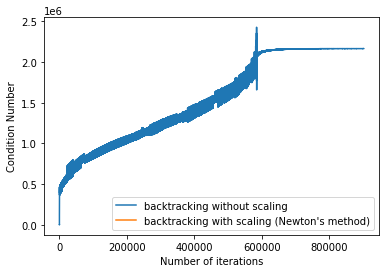

In [62]:
#we will plot the function values and check the behavior
plt.plot(cond_no, label = 'backtracking without scaling')
plt.plot(cond_no_scaling, label = "backtracking with scaling (Newton's method)")
plt.xlabel('Number of iterations')
plt.ylabel('Condition Number')
plt.legend()
plt.show()

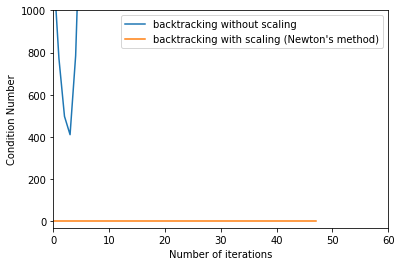

In [63]:
#we will plot the function values and check the behavior
plt.plot(cond_no, label = 'backtracking without scaling')
plt.plot(cond_no_scaling, label = "backtracking with scaling (Newton's method)")
plt.xlabel('Number of iterations')
plt.ylabel('Condition Number')
plt.xlim(0, 60)
plt.ylim(-30,1000)
plt.legend()
plt.show()

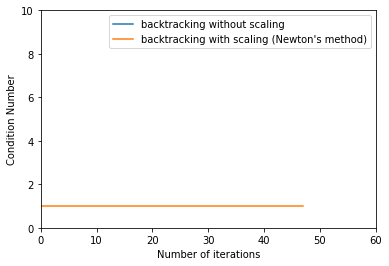

In [64]:
#we will plot the function values and check the behavior
plt.plot(cond_no, label = 'backtracking without scaling')
plt.plot(cond_no_scaling, label = "backtracking with scaling (Newton's method)")
plt.xlabel('Number of iterations')
plt.ylabel('Condition Number')
plt.xlim(0, 60)
plt.ylim(0,10)
plt.legend()
plt.show()